# CLTV Prediction with BG-NBD and Gamma-Gamma

# Business Problem
**FLO wants to establish a roadmap for its sales and marketing activities. In order for the company to make medium to long-term plans, it is necessary to estimate the potential value that existing customers will provide to the company in the future.**

# Dataset Story
**The dataset consists of information obtained from the past shopping behaviors of customers who made their last purchases from Flo as OmniChannel (shopping both online and offline) during the years 2020 - 2021.**

| **Column Name**                         | **Description**                                                                                  |
|-----------------------------------------|--------------------------------------------------------------------------------------------------|
| `master_id`                             | Unique customer ID                                                                             |
| `order_channel`                         | The channel used for shopping on the platform (Android, iOS, Desktop, Mobile, Offline)          |
| `last_order_channel`                    | The channel used for the most recent purchase                                                    |
| `first_order_date`                      | The date of the customer’s first purchase                                                        |
| `last_order_date`                       | The date of the customer’s last purchase                                                         |
| `last_order_date_online`                | The date of the customer’s last purchase on the online platform                                  |
| `last_order_date_offline`               | The date of the customer’s last purchase on the offline platform                                 |
| `order_num_total_ever_online`           | Total number of purchases made by the customer on the online platform                           |
| `order_num_total_ever_offline`          | Total number of purchases made by the customer on the offline platform                          |
| `customer_value_total_ever_offline`     | Total amount spent by the customer on offline purchases                                         |
| `customer_value_total_ever_online`      | Total amount spent by the customer on online purchases                                          |
| `interested_in_categories_12`           | List of categories the customer has shopped in during the last 12 months                        |


# IMPORTINGS

In [91]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

# Data Understanding

In [4]:
df_ = pd.read_csv("/Users/mustafaemircan/PycharmProjects/MiuulBootcamp/PROJECTS/CRM PROJECTS/CLTV PROJECTS/CaseStudy1/flo_data_20k.csv")
df = df_.copy()

In [5]:
df.head()

master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop   

  first_order_date last_order_date last_order_date_online  \
0       2020-10-30      2021-02-26             2021-02-21   
1       2017-02-08      2021-02-16             2021-02-16   
2       2019-11-27      2020-11-27             2020-11-27   
3       2021-01-06      2021-01-17             2021-01-17   
4       2019-08-03      2021-03-07             2021-03-07   

  last_order_date_offline  order_num_total_ever_online  \
0              2021-02-26                         4.00   
1              2020-01-10                        19.00   
2              2019-12-01                         3.00   
3              2021-01-06                         1.00   
4              2019-08-03                         1.00   

   order_num_total_ever_offline  customer_value_total_ever_offline  \
0                          1.00                             139.99   
1                          2.00                             159.97   
2                          2.00                             189.97   
3                          1.00                              39.99   
4                          1.00                              49.99   

   customer_value_total_ever_online       interested_in_categories_12  
0                            799.38                           [KADIN]  
1                           1853.58  [ERKEK, COCUK, KADIN, AKTIFSPOR]  
2                            395.35                    [ERKEK, KADIN]  
3                             81.98               [AKTIFCOCUK, COCUK]  
4                            159.99                       [AKTIFSPOR]

# We defined the `outlier_thresholds` and `replace_with_thresholds` functions needed to handle outliers.

In [99]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

In [101]:
df.describe().T

count                           mean  \
first_order_date                     19945  2019-03-22 16:43:55.246929152   
last_order_date                      19945  2021-01-17 12:59:57.653547264   
last_order_date_online               19945  2020-08-10 01:08:52.644773376   
last_order_date_offline              19945  2020-05-17 12:07:24.021058048   
order_num_total_ever_online       19945.00                           3.09   
order_num_total_ever_offline      19945.00                           1.89   
customer_value_total_ever_offline 19945.00                         251.92   
customer_value_total_ever_online  19945.00                         489.71   
order_num_total                   19945.00                           4.98   
customer_value_total              19945.00                         741.63   

                                                   min                  25%  \
first_order_date                   2013-01-14 00:00:00  2019-02-16 00:00:00   
last_order_date                    2020-05-30 00:00:00  2020-11-11 00:00:00   
last_order_date_online             2014-02-24 00:00:00  2020-06-18 00:00:00   
last_order_date_offline            2019-01-22 00:00:00  2019-11-04 00:00:00   
order_num_total_ever_online                       1.00                 1.00   
order_num_total_ever_offline                      1.00                 1.00   
customer_value_total_ever_offline                10.00                99.99   
customer_value_total_ever_online                 12.99               149.98   
order_num_total                                   2.00                 3.00   
customer_value_total                             44.98               339.98   

                                                   50%                  75%  \
first_order_date                   2019-08-20 00:00:00  2020-01-01 00:00:00   
last_order_date                    2021-02-10 00:00:00  2021-04-19 00:00:00   
last_order_date_online             2020-12-14 00:00:00  2021-04-05 00:00:00   
last_order_date_offline            2020-06-22 00:00:00  2020-12-25 00:00:00   
order_num_total_ever_online                       2.00                 4.00   
order_num_total_ever_offline                      1.00                 2.00   
customer_value_total_ever_offline               179.98               319.97   
customer_value_total_ever_online                286.46               578.44   
order_num_total                                   4.00                 6.00   
customer_value_total                            545.27               897.78   

                                                   max    std  
first_order_date                   2021-05-27 00:00:00    NaN  
last_order_date                    2021-05-30 00:00:00    NaN  
last_order_date_online             2021-05-30 00:00:00    NaN  
last_order_date_offline            2021-05-28 00:00:00    NaN  
order_num_total_ever_online                      48.50   3.81  
order_num_total_ever_offline                     16.00   1.43  
customer_value_total_ever_offline              3019.88 251.02  
customer_value_total_ever_online               7799.54 632.61  
order_num_total                                  57.00   4.12  
customer_value_total                           9063.30 687.90

# We performed outlier suppression.

In [102]:
columns = ["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online"]
for col in columns:
    replace_with_thresholds(df, col)

In [103]:
df.describe().T

count                           mean  \
first_order_date                     19945  2019-03-22 16:43:55.246929152   
last_order_date                      19945  2021-01-17 12:59:57.653547264   
last_order_date_online               19945  2020-08-10 01:08:52.644773376   
last_order_date_offline              19945  2020-05-17 12:07:24.021058048   
order_num_total_ever_online       19945.00                           3.09   
order_num_total_ever_offline      19945.00                           1.89   
customer_value_total_ever_offline 19945.00                         251.92   
customer_value_total_ever_online  19945.00                         489.71   
order_num_total                   19945.00                           4.98   
customer_value_total              19945.00                         741.63   

                                                   min                  25%  \
first_order_date                   2013-01-14 00:00:00  2019-02-16 00:00:00   
last_order_date                    2020-05-30 00:00:00  2020-11-11 00:00:00   
last_order_date_online             2014-02-24 00:00:00  2020-06-18 00:00:00   
last_order_date_offline            2019-01-22 00:00:00  2019-11-04 00:00:00   
order_num_total_ever_online                       1.00                 1.00   
order_num_total_ever_offline                      1.00                 1.00   
customer_value_total_ever_offline                10.00                99.99   
customer_value_total_ever_online                 12.99               149.98   
order_num_total                                   2.00                 3.00   
customer_value_total                             44.98               339.98   

                                                   50%                  75%  \
first_order_date                   2019-08-20 00:00:00  2020-01-01 00:00:00   
last_order_date                    2021-02-10 00:00:00  2021-04-19 00:00:00   
last_order_date_online             2020-12-14 00:00:00  2021-04-05 00:00:00   
last_order_date_offline            2020-06-22 00:00:00  2020-12-25 00:00:00   
order_num_total_ever_online                       2.00                 4.00   
order_num_total_ever_offline                      1.00                 2.00   
customer_value_total_ever_offline               179.98               319.97   
customer_value_total_ever_online                286.46               578.44   
order_num_total                                   4.00                 6.00   
customer_value_total                            545.27               897.78   

                                                   max    std  
first_order_date                   2021-05-27 00:00:00    NaN  
last_order_date                    2021-05-30 00:00:00    NaN  
last_order_date_online             2021-05-30 00:00:00    NaN  
last_order_date_offline            2021-05-28 00:00:00    NaN  
order_num_total_ever_online                      48.50   3.81  
order_num_total_ever_offline                     16.00   1.43  
customer_value_total_ever_offline              3019.88 251.02  
customer_value_total_ever_online               7799.54 632.61  
order_num_total                                  57.00   4.12  
customer_value_total                           9063.30 687.90

# We created new variables for each customer's total number of purchases and total spending.

In [104]:
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [105]:
df.head()

master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop   

  first_order_date last_order_date last_order_date_online  \
0       2020-10-30      2021-02-26             2021-02-21   
1       2017-02-08      2021-02-16             2021-02-16   
2       2019-11-27      2020-11-27             2020-11-27   
3       2021-01-06      2021-01-17             2021-01-17   
4       2019-08-03      2021-03-07             2021-03-07   

  last_order_date_offline  order_num_total_ever_online  \
0              2021-02-26                         4.00   
1              2020-01-10                        19.00   
2              2019-12-01                         3.00   
3              2021-01-06                         1.00   
4              2019-08-03                         1.00   

   order_num_total_ever_offline  customer_value_total_ever_offline  \
0                          1.00                             139.99   
1                          2.00                             159.97   
2                          2.00                             189.97   
3                          1.00                              39.99   
4                          1.00                              49.99   

   customer_value_total_ever_online       interested_in_categories_12  \
0                            799.38                           [KADIN]   
1                           1853.58  [ERKEK, COCUK, KADIN, AKTIFSPOR]   
2                            395.35                    [ERKEK, KADIN]   
3                             81.98               [AKTIFCOCUK, COCUK]   
4                            159.99                       [AKTIFSPOR]   

   order_num_total  customer_value_total  
0             5.00                939.37  
1            21.00               2013.55  
2             5.00                585.32  
3             2.00                121.97  
4             2.00                209.98

# We converted date variables to `datetime`.

In [106]:
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

# Creating the CLTV Data Structure

### Determining the analysis date

In [108]:
df["last_order_date"].max()     #2021-05-30
analysis_date = dt.datetime(2021, 6, 1)
analysis_date

datetime.datetime(2021, 6, 1, 0, 0)

In [109]:
df.groupby("master_id").agg({"customer_value_total": "sum"})

customer_value_total
master_id                                                 
00016786-2f5a-11ea-bb80-000d3a38a36f                776.07
00034aaa-a838-11e9-a2fc-000d3a38a36f                269.47
000be838-85df-11ea-a90b-000d3a38a36f                722.69
000c1fe2-a8b7-11ea-8479-000d3a38a36f                874.16
000f5e3e-9dde-11ea-80cd-000d3a38a36f               1620.33
00136ce2-a562-11e9-a2fc-000d3a38a36f                359.45
00142f9a-7af6-11eb-8460-000d3a38a36f                404.94
0014778a-5b11-11ea-9a2c-000d3a38a36f                727.43
0018c6aa-ab6c-11e9-a2fc-000d3a38a36f                317.91
0022f41e-5597-11eb-9e65-000d3a38a36f                154.98
0025f17c-eeaf-11ea-bb5a-000d3a38a36f                791.97
00263f1a-210a-11ea-b50a-000d3a38a36f                501.94
00266a76-312c-11ea-b884-000d3a38a36f               1249.58
002bdaa8-9ee9-11ea-80cd-000d3a38a36f                962.87
003334c0-2b61-11ea-9d27-000d3a38a36f                512.95
0033a502-5bf1-11ea-829b-000d3a38a36f                788.73
0033f078-7359-11ea-92d0-000d3a38a36f                153.98
003705ee-a800-11e9-a2fc-000d3a38a36f                304.26
003903e0-abce-11e9-a2fc-000d3a38a36f                577.47
003c4ebc-aa23-11e9-a2fc-000d3a38a36f                360.76
00414e84-adc6-11e9-a2fc-000d3a38a36f                303.44
00425f66-5b51-11ea-96d8-000d3a38a36f                419.96
004bec18-9f7a-11e9-a2fc-000d3a38a36f                684.91
004d5204-2037-11ea-87bf-000d3a38a36f               1170.76
00521bd0-b0c6-11e9-9757-000d3a38a36f                157.47
00534fe4-a6b4-11e9-a2fc-000d3a38a36f                800.59
0053a6ea-ad0a-11e9-a2fc-000d3a38a36f                394.49
00596df0-abca-11e9-a2fc-000d3a38a36f               1408.36
005c7914-9e78-11e9-9897-000d3a38a36f                264.48
006633b6-a6b9-11e9-a2fc-000d3a38a36f               2050.50
00663454-520f-11ea-a243-000d3a38a36f                361.94
0067708e-1ec6-11ea-aa32-000d3a38a36f                397.30
0067e5b2-5447-11ea-b1db-000d3a38a36f                282.36
006981e0-66eb-11ea-82da-000d3a38a36f                234.48
006bb20e-a9a8-11e9-a2fc-000d3a38a36f                620.41
00736820-a834-11e9-a2fc-000d3a38a36f                714.53
00740768-d6d7-11e9-93bc-000d3a38a36f                294.45
00753baa-0090-11ea-a5e8-000d3a38a36f                516.67
007a2954-4b66-11eb-806e-000d3a38a36f                572.98
007bc81a-234b-11eb-99f8-000d3a38a36f                441.47
007cdfe4-1f54-11ea-87bf-000d3a38a36f                778.88
007e118c-5bf1-11ea-97fc-000d3a38a36f                340.91
007e8be6-a871-11e9-a2fc-000d3a38a36f                550.59
008073a4-bbab-11ea-a0c9-000d3a38a36f                532.82
0082e79e-5b50-11ea-ba9b-000d3a38a36f                279.97
00842ccc-15ea-11ea-aa74-000d3a38a36f                189.97
00844650-a937-11e9-a2fc-000d3a38a36f                746.70
0087ec3e-ad64-11e9-a2fc-000d3a38a36f                390.95
00898b48-5b92-11ea-a592-000d3a38a36f                260.81
009293fe-1f3e-11ea-87bf-000d3a38a36f                725.18
009e2910-1252-11ea-a001-000d3a38a36f               1109.60
00a10df4-5f9d-11ea-8dd8-000d3a38a36f                906.34
00a3f278-ddbe-11e9-9cd3-000d3a38a36f                431.96
00a5009a-2558-11eb-a59b-000d3a38a36f                245.87
00a7bc8e-b085-11e9-9757-000d3a38a36f                610.33
00a9f3a6-5318-11ea-acd3-000d3a38a36f                229.96
00b37b0c-b0a6-11e9-9757-000d3a38a36f               1042.77
00b38808-541c-11ea-b1db-000d3a38a36f                456.22
00b3ee24-aa44-11e9-a2fc-000d3a38a36f               2027.78
00c2168c-a875-11e9-a2fc-000d3a38a36f                381.96
00c4e990-edfb-11e9-9346-000d3a38a36f                592.86
00cf8494-9da2-11e9-9897-000d3a38a36f               6275.33
00d2268e-5b36-11ea-8ca6-000d3a38a36f                255.56
00d37630-2b32-11ea-9d27-000d3a38a36f               2349.82
00d46324-8f9b-11ea-8f41-000d3a38a36f                427.90
00dc8510-908d-11eb-bae6-000d3a38a36f                361.00
00dfa312-e5e4-11e9-ad00-00

In [110]:
df.groupby("master_id").agg({"order_num_total": "sum"})

order_num_total
master_id                                            
00016786-2f5a-11ea-bb80-000d3a38a36f             5.00
00034aaa-a838-11e9-a2fc-000d3a38a36f             3.00
000be838-85df-11ea-a90b-000d3a38a36f             4.00
000c1fe2-a8b7-11ea-8479-000d3a38a36f             7.00
000f5e3e-9dde-11ea-80cd-000d3a38a36f             7.00
00136ce2-a562-11e9-a2fc-000d3a38a36f             2.00
00142f9a-7af6-11eb-8460-000d3a38a36f             3.00
0014778a-5b11-11ea-9a2c-000d3a38a36f             3.00
0018c6aa-ab6c-11e9-a2fc-000d3a38a36f             2.00
0022f41e-5597-11eb-9e65-000d3a38a36f             2.00
0025f17c-eeaf-11ea-bb5a-000d3a38a36f             4.00
00263f1a-210a-11ea-b50a-000d3a38a36f             3.00
00266a76-312c-11ea-b884-000d3a38a36f             7.00
002bdaa8-9ee9-11ea-80cd-000d3a38a36f             3.00
003334c0-2b61-11ea-9d27-000d3a38a36f             3.00
0033a502-5bf1-11ea-829b-000d3a38a36f             4.00
0033f078-7359-11ea-92d0-000d3a38a36f             2.00
003705ee-a800-11e9-a2fc-000d3a38a36f             3.00
003903e0-abce-11e9-a2fc-000d3a38a36f             5.00
003c4ebc-aa23-11e9-a2fc-000d3a38a36f             4.00
00414e84-adc6-11e9-a2fc-000d3a38a36f             3.00
00425f66-5b51-11ea-96d8-000d3a38a36f             4.00
004bec18-9f7a-11e9-a2fc-000d3a38a36f            12.00
004d5204-2037-11ea-87bf-000d3a38a36f             8.00
00521bd0-b0c6-11e9-9757-000d3a38a36f             3.00
00534fe4-a6b4-11e9-a2fc-000d3a38a36f            16.00
0053a6ea-ad0a-11e9-a2fc-000d3a38a36f             3.00
00596df0-abca-11e9-a2fc-000d3a38a36f             4.00
005c7914-9e78-11e9-9897-000d3a38a36f             2.00
006633b6-a6b9-11e9-a2fc-000d3a38a36f            19.00
00663454-520f-11ea-a243-000d3a38a36f             4.00
0067708e-1ec6-11ea-aa32-000d3a38a36f             5.00
0067e5b2-5447-11ea-b1db-000d3a38a36f             3.00
006981e0-66eb-11ea-82da-000d3a38a36f             2.00
006bb20e-a9a8-11e9-a2fc-000d3a38a36f             3.00
00736820-a834-11e9-a2fc-000d3a38a36f             9.00
00740768-d6d7-11e9-93bc-000d3a38a36f             4.00
00753baa-0090-11ea-a5e8-000d3a38a36f             4.00
007a2954-4b66-11eb-806e-000d3a38a36f             4.00
007bc81a-234b-11eb-99f8-000d3a38a36f             3.00
007cdfe4-1f54-11ea-87bf-000d3a38a36f             8.00
007e118c-5bf1-11ea-97fc-000d3a38a36f             3.00
007e8be6-a871-11e9-a2fc-000d3a38a36f             5.00
008073a4-bbab-11ea-a0c9-000d3a38a36f             5.00
0082e79e-5b50-11ea-ba9b-000d3a38a36f             2.00
00842ccc-15ea-11ea-aa74-000d3a38a36f             3.00
00844650-a937-11e9-a2fc-000d3a38a36f             3.00
0087ec3e-ad64-11e9-a2fc-000d3a38a36f             5.00
00898b48-5b92-11ea-a592-000d3a38a36f             4.00
009293fe-1f3e-11ea-87bf-000d3a38a36f             6.00
009e2910-1252-11ea-a001-000d3a38a36f             7.00
00a10df4-5f9d-11ea-8dd8-000d3a38a36f            13.00
00a3f278-ddbe-11e9-9cd3-000d3a38a36f             3.00
00a5009a-2558-11eb-a59b-000d3a38a36f             2.00
00a7bc8e-b085-11e9-9757-000d3a38a36f             5.00
00a9f3a6-5318-11ea-acd3-000d3a38a36f             2.00
00b37b0c-b0a6-11e9-9757-000d3a38a36f             8.00
00b38808-541c-11ea-b1db-000d3a38a36f             3.00
00b3ee24-aa44-11e9-a2fc-000d3a38a36f             8.00
00c2168c-a875-11e9-a2fc-000d3a38a36f             3.00
00c4e990-edfb-11e9-9346-000d3a38a36f             5.00
00cf8494-9da2-11e9-9897-000d3a38a36f            53.00
00d2268e-5b36-11ea-8ca6-000d3a38a36f             2.00
00d37630-2b32-11ea-9d27-000d3a38a36f             6.00
00d46324-8f9b-11ea-8f41-000d3a38a36f             4.00
00dc8510-908d-11eb-bae6-000d3a38a36f             3.00
00dfa312-e5e4-11e9-ad00-000d3a38a36f             4.00
00e58b24-5b4b-11ea-ac70-000d3a38a36f             2.00
00e65764-fe5a-11e9-a5e8-000d3a38a36f             4.00
00eb056a-38df-11ea-85d6-000d3a38a36f             2.00
00ede098-9e6e-11e9-9897-000d3a38a36f             2.00
00ef026e-5428-11ea-b1db-000d3a38a36f             2.00
00ef42be-15e5-11ea-aa74-000d3a38a36f      

# We created a CLTV dataframe containing Recency, Frequency, T value, and Monetary values.

- **BG/NBD**
  - **Recency**: The time elapsed since the last purchase (in weeks) (last purchase - first purchase) (specific to the user)
  - **T**: The age of the customer (in weeks) (how long ago the first purchase was made from the analysis date)

- **GAMMA GAMMA**
  - **Frequency**: Total number of repeat purchases (frequency > 1)
  - **Monetary**: Average revenue per purchase (average)

In [111]:
df.head()

master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop   

  first_order_date last_order_date last_order_date_online  \
0       2020-10-30      2021-02-26             2021-02-21   
1       2017-02-08      2021-02-16             2021-02-16   
2       2019-11-27      2020-11-27             2020-11-27   
3       2021-01-06      2021-01-17             2021-01-17   
4       2019-08-03      2021-03-07             2021-03-07   

  last_order_date_offline  order_num_total_ever_online  \
0              2021-02-26                         4.00   
1              2020-01-10                        19.00   
2              2019-12-01                         3.00   
3              2021-01-06                         1.00   
4              2019-08-03                         1.00   

   order_num_total_ever_offline  customer_value_total_ever_offline  \
0                          1.00                             139.99   
1                          2.00                             159.97   
2                          2.00                             189.97   
3                          1.00                              39.99   
4                          1.00                              49.99   

   customer_value_total_ever_online       interested_in_categories_12  \
0                            799.38                           [KADIN]   
1                           1853.58  [ERKEK, COCUK, KADIN, AKTIFSPOR]   
2                            395.35                    [ERKEK, KADIN]   
3                             81.98               [AKTIFCOCUK, COCUK]   
4                            159.99                       [AKTIFSPOR]   

   order_num_total  customer_value_total  
0             5.00                939.37  
1            21.00               2013.55  
2             5.00                585.32  
3             2.00                121.97  
4             2.00                209.98

In [112]:
cltv_df = pd.DataFrame()

In [113]:
cltv_df["customer id"] = df["master_id"]

In [114]:
cltv_df["recency_cltv_weekly"] = ((df["last_order_date"] - df["first_order_date"]).dt.days) / 7

In [115]:
cltv_df["T_weekly"] = ((analysis_date - df["first_order_date"]).dt.days) / 7

In [116]:
cltv_df["frequency"] = df["order_num_total"]

In [117]:
cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]

In [118]:
cltv_df.head()

customer id  recency_cltv_weekly  T_weekly  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f                17.00     30.57   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f               209.86    224.86   
2  69b69676-1a40-11ea-941b-000d3a38a36f                52.29     78.86   
3  1854e56c-491f-11eb-806e-000d3a38a36f                 1.57     20.86   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f                83.14     95.43   

   frequency  monetary_cltv_avg  
0       5.00             187.87  
1      21.00              95.88  
2       5.00             117.06  
3       2.00              60.98  
4       2.00             104.99

# We fitted the BG/NBD model.

In [119]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [120]:
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

/Users/mustafaemircan/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

# We predicted the expected purchases from customers over the next 3 months.

In [121]:
cltv_df["exp_sales_3"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 3,
                                                        cltv_df["frequency"],
                                                        cltv_df["recency_cltv_weekly"],
                                                        cltv_df["T_weekly"])

# We predicted the expected purchases from customers over the next 6 months.

In [122]:
cltv_df["exp_sales_6"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6,
                                                        cltv_df["frequency"],
                                                        cltv_df["recency_cltv_weekly"],
                                                        cltv_df["T_weekly"])

# We compared these two predictions.

In [123]:
cltv_df.sort_values("exp_sales_3", ascending=False).head(10)

customer id  recency_cltv_weekly  T_weekly  \
7330   a4d534a2-5b1b-11eb-8dbd-000d3a38a36f                62.71     67.29   
15611  4a7e875e-e6ce-11ea-8f44-000d3a38a36f                39.71     40.00   
8328   1902bf80-0035-11eb-8341-000d3a38a36f                28.86     33.29   
19538  55d54d9e-8ac7-11ea-8ec0-000d3a38a36f                52.57     58.71   
14373  f00ad516-c4f4-11ea-98f7-000d3a38a36f                38.00     46.43   
10489  7af5cd16-b100-11e9-9757-000d3a38a36f               103.14    111.86   
4315   d5ef8058-a5c6-11e9-a2fc-000d3a38a36f               133.14    147.14   
6756   27310582-6362-11ea-a6dc-000d3a38a36f                62.71     64.14   
6666   53fe00d4-7b7a-11eb-960b-000d3a38a36f                 9.71     13.00   
10536  e143b6fa-d6f8-11e9-93bc-000d3a38a36f               104.57    113.43   

       frequency  monetary_cltv_avg  exp_sales_3  exp_sales_6  
7330       52.50             164.63         4.70         9.40  
15611      29.00             165.30         3.37         6.75  
8328       25.00              97.44         3.14         6.28  
19538      31.00             228.53         3.08         6.17  
14373      27.00             141.35         3.00         6.00  
10489      43.00             157.11         2.98         5.96  
4315       49.50             160.20         2.86         5.71  
6756       29.00             168.88         2.79         5.59  
6666       17.00             259.87         2.78         5.56  
10536      40.00             176.20         2.76         5.53

In [124]:
cltv_df.sort_values("exp_sales_6", ascending=False).head(10)

customer id  recency_cltv_weekly  T_weekly  \
7330   a4d534a2-5b1b-11eb-8dbd-000d3a38a36f                62.71     67.29   
15611  4a7e875e-e6ce-11ea-8f44-000d3a38a36f                39.71     40.00   
8328   1902bf80-0035-11eb-8341-000d3a38a36f                28.86     33.29   
19538  55d54d9e-8ac7-11ea-8ec0-000d3a38a36f                52.57     58.71   
14373  f00ad516-c4f4-11ea-98f7-000d3a38a36f                38.00     46.43   
10489  7af5cd16-b100-11e9-9757-000d3a38a36f               103.14    111.86   
4315   d5ef8058-a5c6-11e9-a2fc-000d3a38a36f               133.14    147.14   
6756   27310582-6362-11ea-a6dc-000d3a38a36f                62.71     64.14   
6666   53fe00d4-7b7a-11eb-960b-000d3a38a36f                 9.71     13.00   
10536  e143b6fa-d6f8-11e9-93bc-000d3a38a36f               104.57    113.43   

       frequency  monetary_cltv_avg  exp_sales_3  exp_sales_6  
7330       52.50             164.63         4.70         9.40  
15611      29.00             165.30         3.37         6.75  
8328       25.00              97.44         3.14         6.28  
19538      31.00             228.53         3.08         6.17  
14373      27.00             141.35         3.00         6.00  
10489      43.00             157.11         2.98         5.96  
4315       49.50             160.20         2.86         5.71  
6756       29.00             168.88         2.79         5.59  
6666       17.00             259.87         2.78         5.56  
10536      40.00             176.20         2.76         5.53

# Evaluating the Prediction Results
### We are comparing the actual and predicted values:

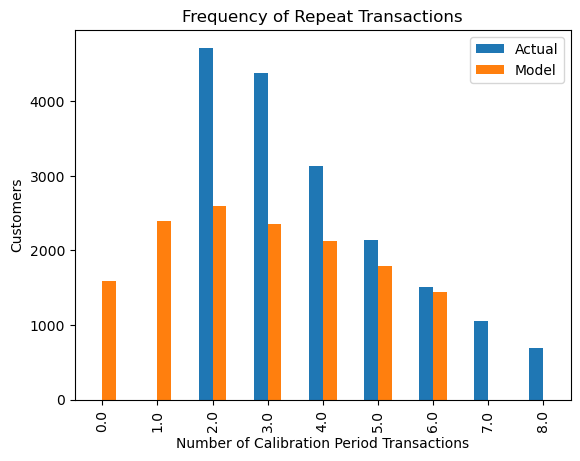

In [125]:
plot_period_transactions(bgf)
plt.show()

# We fitted the Gamma-Gamma model.

In [126]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [128]:
cltv_df['frequency'] = cltv_df['frequency'].round(0).astype(int)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

# We predicted the average value that customers will leave.

In [129]:
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                        cltv_df["monetary_cltv_avg"])

In [130]:
cltv_df.head(10)

customer id  recency_cltv_weekly  T_weekly  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f                17.00     30.57   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f               209.86    224.86   
2  69b69676-1a40-11ea-941b-000d3a38a36f                52.29     78.86   
3  1854e56c-491f-11eb-806e-000d3a38a36f                 1.57     20.86   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f                83.14     95.43   
5  e585280e-aae1-11e9-a2fc-000d3a38a36f               120.86    132.29   
6  c445e4ee-6242-11ea-9d1a-000d3a38a36f                32.57     64.86   
7  3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f                12.71     54.57   
8  cfbda69e-5b4f-11ea-aca7-000d3a38a36f                58.43     70.71   
9  1143f032-440d-11ea-8b43-000d3a38a36f                61.71     96.00   

   frequency  monetary_cltv_avg  exp_sales_3  exp_sales_6  exp_average_value  
0          5             187.87         0.97         1.95             193.63  
1         21              95.88         0.98         1.97              96.67  
2          5             117.06         0.67         1.34             120.97  
3          2              60.98         0.70         1.40              67.32  
4          2             104.99         0.40         0.79             114.33  
5          3              66.95         0.38         0.77              71.35  
6          4              93.98         0.65         1.30              98.13  
7          2              81.81         0.52         1.04              89.57  
8          5             210.94         0.71         1.42             217.30  
9          2              82.98         0.39         0.79              90.81

In [131]:
cltv_df.sort_values("exp_average_value", ascending=False).head(10)

customer id  recency_cltv_weekly  T_weekly  \
9055   47a642fe-975b-11eb-8c2a-000d3a38a36f                 2.86      7.86   
17323  f59053e2-a503-11e9-a2fc-000d3a38a36f                51.71    101.00   
15516  9083981a-f59e-11e9-841e-000d3a38a36f                63.57     83.86   
6402   851de3b4-8f0c-11eb-8cb8-000d3a38a36f                 8.29      9.43   
16410  6fecd6c8-261a-11ea-8e1c-000d3a38a36f                57.00     94.86   
1853   f02473b0-43c3-11eb-806e-000d3a38a36f                17.29     23.14   
7936   ae4ce104-dbd4-11ea-8757-000d3a38a36f                 3.71     42.00   
9738   3a27b334-dff4-11ea-acaa-000d3a38a36f                40.00     41.14   
12828  0c24fc44-2ac8-11ea-9d27-000d3a38a36f                68.00     84.29   
2291   26ac1432-1dd3-11ea-8bf2-000d3a38a36f                55.71     97.71   

       frequency  monetary_cltv_avg  exp_sales_3  exp_sales_6  \
9055           4            1401.77         1.09         2.19   
17323          7            1106.47         0.72         1.44   
15516          4            1090.36         0.57         1.15   
6402           2             862.69         0.79         1.59   
16410          2             859.58         0.40         0.79   
1853           2             835.88         0.68         1.37   
7936           3             844.35         0.68         1.35   
9738           3             837.06         0.68         1.36   
12828          2             779.26         0.42         0.85   
2291           3             780.56         0.46         0.92   

       exp_average_value  
9055             1449.03  
17323            1127.61  
15516            1127.35  
6402              923.68  
16410             920.36  
1853              895.04  
7936              883.29  
9738              875.67  
12828             834.57  
2291              816.66

# We calculated the 6-month CLTV.

In [132]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency_cltv_weekly"],
                                   cltv_df["T_weekly"],
                                   cltv_df["monetary_cltv_avg"],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)

In [133]:
cltv.head()

0   395.73
1   199.43
2   170.22
3    98.95
4    95.01
Name: clv, dtype: float64

In [134]:
cltv_df["scaled_cltv"] = cltv 

In [135]:
cltv_df.head()

customer id  recency_cltv_weekly  T_weekly  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f                17.00     30.57   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f               209.86    224.86   
2  69b69676-1a40-11ea-941b-000d3a38a36f                52.29     78.86   
3  1854e56c-491f-11eb-806e-000d3a38a36f                 1.57     20.86   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f                83.14     95.43   

   frequency  monetary_cltv_avg  exp_sales_3  exp_sales_6  exp_average_value  \
0          5             187.87         0.97         1.95             193.63   
1         21              95.88         0.98         1.97              96.67   
2          5             117.06         0.67         1.34             120.97   
3          2              60.98         0.70         1.40              67.32   
4          2             104.99         0.40         0.79             114.33   

   scaled_cltv  
0       395.73  
1       199.43  
2       170.22  
3        98.95  
4        95.01

# We observed the top 20 customers with the highest CLTV values.

In [136]:
cltv_df.sort_values("scaled_cltv", ascending=False).head(20)

customer id  recency_cltv_weekly  T_weekly  \
9055   47a642fe-975b-11eb-8c2a-000d3a38a36f                 2.86      7.86   
13880  7137a5c0-7aad-11ea-8f20-000d3a38a36f                 6.14     13.14   
17323  f59053e2-a503-11e9-a2fc-000d3a38a36f                51.71    101.00   
12438  625f40a2-5bd2-11ea-98b0-000d3a38a36f                74.29     74.57   
8868   9ce6e520-89b0-11ea-a6e7-000d3a38a36f                 3.43     34.43   
7330   a4d534a2-5b1b-11eb-8dbd-000d3a38a36f                62.71     67.29   
6402   851de3b4-8f0c-11eb-8cb8-000d3a38a36f                 8.29      9.43   
6666   53fe00d4-7b7a-11eb-960b-000d3a38a36f                 9.71     13.00   
19538  55d54d9e-8ac7-11ea-8ec0-000d3a38a36f                52.57     58.71   
14858  031b2954-6d28-11eb-99c4-000d3a38a36f                14.86     15.57   
17963  8fd88976-6708-11ea-9d38-000d3a38a36f                50.29     63.29   
15516  9083981a-f59e-11e9-841e-000d3a38a36f                63.57     83.86   
6717   40b4f318-9dfb-11eb-9c47-000d3a38a36f                27.14     33.86   
4157   7eed6468-4540-11ea-acaf-000d3a38a36f                89.14     90.00   
4735   dbabb58e-6312-11ea-a6dc-000d3a38a36f                61.29     64.29   
11694  90f1b7f2-bbad-11ea-a0c9-000d3a38a36f                47.29     48.00   
11179  d2e74a36-3228-11eb-860c-000d3a38a36f                 1.14     26.29   
1853   f02473b0-43c3-11eb-806e-000d3a38a36f                17.29     23.14   
5775   e31293ac-d63a-11e9-93bc-000d3a38a36f                91.71     93.14   
7312   90befc98-925a-11eb-b584-000d3a38a36f                 4.14      8.86   

       frequency  monetary_cltv_avg  exp_sales_3  exp_sales_6  \
9055           4            1401.77         1.09         2.19   
13880         11             758.04         1.97         3.94   
17323          7            1106.47         0.72         1.44   
12438         16             501.85         1.57         3.13   
8868           8             601.23         1.27         2.53   
7330          52             164.63         4.70         9.40   
6402           2             862.69         0.79         1.59   
6666          17             259.87         2.78         5.56   
19538         31             228.53         3.08         6.17   
14858          3             743.59         0.87         1.74   
17963          7             694.20         0.92         1.84   
15516          4            1090.36         0.57         1.15   
6717           7             544.70         1.16         2.33   
4157          27             289.76         2.21         4.43   
4735          13             442.12         1.42         2.85   
11694          6             647.34         0.93         1.87   
11179          3             750.57         0.78         1.56   
1853           2             835.88         0.68         1.37   
5775           8             727.09         0.83         1.65   
7312           6             431.33         1.36         2.73   

       exp_average_value  scaled_cltv  
9055             1449.03      3327.71  
13880             767.32      3172.22  
17323            1127.61      1708.98  
12438             506.14      1662.52  
8868              611.49      1623.81  
7330              165.12      1613.30  
6402              923.68      1538.86  
6666              262.07      1529.23  
19538             229.61      1485.82  
14858             778.05      1423.00  
17963             707.69      1362.61  
15516            1127.35      1359.44  
6717              555.41      1355.44  
4157              291.29      1353.53  
4735              446.82      1334.83  
11694             662.11      1297.52  
11179             785.34      1286.14  
1853              895.04      1285.23  
5775              739.39      1282.58  
7312              441.40      1263.19

# We created segments based on CLTV.

In [137]:
cltv_df["cltv_segment"] = pd.qcut(cltv_df["scaled_cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.head()

customer id  recency_cltv_weekly  T_weekly  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f                17.00     30.57   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f               209.86    224.86   
2  69b69676-1a40-11ea-941b-000d3a38a36f                52.29     78.86   
3  1854e56c-491f-11eb-806e-000d3a38a36f                 1.57     20.86   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f                83.14     95.43   

   frequency  monetary_cltv_avg  exp_sales_3  exp_sales_6  exp_average_value  \
0          5             187.87         0.97         1.95             193.63   
1         21              95.88         0.98         1.97              96.67   
2          5             117.06         0.67         1.34             120.97   
3          2              60.98         0.70         1.40              67.32   
4          2             104.99         0.40         0.79             114.33   

   scaled_cltv cltv_segment  
0       395.73            A  
1       199.43            B  
2       170.22            B  
3        98.95            D  
4        95.01            D

In [138]:
cltv_df["cltv_segment"].value_counts()

cltv_segment
D    4987
C    4986
B    4986
A    4986
Name: count, dtype: int64

# Distribution of segments based on frequency

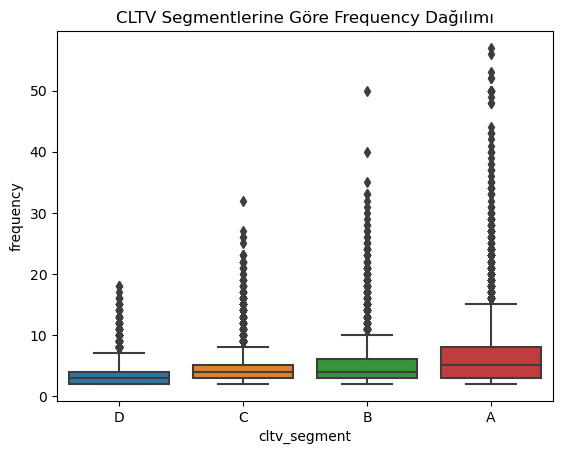

In [139]:
sns.boxplot(x="cltv_segment", y="frequency", data=cltv_df)
plt.title("CLTV Segmentlerine Göre Frequency Dağılımı")
plt.show()

# BONUS: The function-structured version of the entire process

In [140]:
def create_cltv_df(dataframe):

    # Veriyi Hazırlama
    columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
    for col in columns:
        replace_with_thresholds(dataframe, col)

    dataframe["order_num_total"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]
    dataframe["customer_value_total"] = dataframe["customer_value_total_ever_offline"] + dataframe["customer_value_total_ever_online"]
    dataframe = dataframe[~(dataframe["customer_value_total"] == 0) | (dataframe["order_num_total"] == 0)]
    date_columns = dataframe.columns[dataframe.columns.str.contains("date")]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    # CLTV veri yapısının oluşturulması
    dataframe["last_order_date"].max()  # 2021-05-30
    analysis_date = dt.datetime(2021, 6, 1)
    cltv_df = pd.DataFrame()
    cltv_df["customer_id"] = dataframe["master_id"]
    cltv_df["recency_cltv_weekly"] = ((dataframe["last_order_date"] - dataframe["first_order_date"]).dt.days) / 7
    cltv_df["T_weekly"] = ((analysis_date - dataframe["first_order_date"]).dt.days) / 7
    cltv_df["frequency"] = dataframe["order_num_total"]
    cltv_df["monetary_cltv_avg"] = dataframe["customer_value_total"] / dataframe["order_num_total"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

    # BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency_cltv_weekly'],
            cltv_df['T_weekly'])
    cltv_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])
    cltv_df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])

    # # Gamma-Gamma Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    cltv_df['frequency'] = cltv_df['frequency'].round(0).astype(int)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
    cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                           cltv_df['monetary_cltv_avg'])

    # Cltv tahmini
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'],
                                       cltv_df['monetary_cltv_avg'],
                                       time=6,
                                       freq="W",
                                       discount_rate=0.01)
    cltv_df["cltv"] = cltv

    # CLTV segmentleme
    cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

    return cltv_df

In [96]:
cltv_df = create_cltv_df(df)

/Users/mustafaemircan/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [97]:
cltv_df.head(10)

customer_id  recency_cltv_weekly  T_weekly  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f                17.00     30.57   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f               209.86    224.86   
2  69b69676-1a40-11ea-941b-000d3a38a36f                52.29     78.86   
3  1854e56c-491f-11eb-806e-000d3a38a36f                 1.57     20.86   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f                83.14     95.43   
5  e585280e-aae1-11e9-a2fc-000d3a38a36f               120.86    132.29   
6  c445e4ee-6242-11ea-9d1a-000d3a38a36f                32.57     64.86   
7  3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f                12.71     54.57   
8  cfbda69e-5b4f-11ea-aca7-000d3a38a36f                58.43     70.71   
9  1143f032-440d-11ea-8b43-000d3a38a36f                61.71     96.00   

   frequency  monetary_cltv_avg  exp_sales_3_month  exp_sales_6_month  \
0          5             187.87               0.97               1.95   
1         21              95.88               0.98               1.97   
2          5             117.06               0.67               1.34   
3          2              60.98               0.70               1.40   
4          2             104.99               0.40               0.79   
5          3              66.95               0.38               0.77   
6          4              93.98               0.65               1.30   
7          2              81.81               0.52               1.04   
8          5             210.94               0.71               1.42   
9          2              82.98               0.39               0.79   

   exp_average_value   cltv cltv_segment  
0             193.63 395.73            A  
1              96.67 199.43            B  
2             120.97 170.22            B  
3              67.32  98.95            D  
4             114.33  95.01            D  
5              71.35  57.43            D  
6              98.13 134.28            C  
7              89.57  97.70            D  
8             217.30 322.73            A  
9              90.81  75.22            D

# THANKS..